## This code takes the file with weekly crash data and roadway attributes and appies the short-term network screening method to calculate crash risk for each segment on the Interstates

In [1]:
from scipy.special import gamma
import math
import numpy as np
import pandas as pd
from scipy.stats import norm

#### importing segment data with crash & roadway attributes

In [2]:
p = r"anonymized_data_with_crashcount_42_week.csv"
df = pd.read_csv(p)
df.head()

week_number  hourly_volume  Actual_class  LEFT_SHOUL_x_1.0  \
0            1    1223.478499             1               0.0   
1            2    1223.478499             1               0.0   
2            3    1223.478499             1               0.0   
3            4    1223.478499             1               0.0   
4            5    1222.868308             1               0.0   

   LEFT_SHOUL_x_nan  LEFT_SHOUL_y_2.0  LEFT_SHOUL_y_nan  MEDIAN_TYP_1.0  \
0               1.0               1.0               0.0             0.0   
1               1.0               1.0               0.0             0.0   
2               1.0               1.0               0.0             0.0   
3               1.0               1.0               0.0             0.0   
4               1.0               1.0               0.0             0.0   

   MEDIAN_TYP_2.0  MEDIAN_TYP_3.0  ...  Median_width_50_75  \
0             1.0             0.0  ...                 1.0   
1             1.0             0.0  ...                 1.0   
2             1.0             0.0  ...                 1.0   
3             1.0             0.0  ...                 1.0   
4             1.0             0.0  ...                 1.0   

   Median_width_above_75  Median_width_below_20  Surf_width_20_40  \
0                    0.0                    0.0               1.0   
1                    0.0                    0.0               1.0   
2                    0.0                    0.0               1.0   
3                    0.0                    0.0               1.0   
4                    0.0                    0.0               1.0   

   Surf_width_40_60  Surf_width_above_60  Surf_width_below_20  crash_count  \
0               0.0                  0.0                  0.0          0.0   
1               0.0                  0.0                  0.0          0.0   
2               0.0                  0.0                  0.0          0.0   
3               0.0                  0.0                  0.0          0.0   
4               0.0                  0.0                  0.0          0.0   

   crashcount_binary  segment_id  
0                  0       seg_1  
1                  0       seg_1  
2                  0       seg_1  
3                  0       seg_1  
4                  0       seg_1  

[5 rows x 54 columns]

In [3]:
df.head()

week_number  hourly_volume  Actual_class  LEFT_SHOUL_x_1.0  \
0            1    1223.478499             1               0.0   
1            2    1223.478499             1               0.0   
2            3    1223.478499             1               0.0   
3            4    1223.478499             1               0.0   
4            5    1222.868308             1               0.0   

   LEFT_SHOUL_x_nan  LEFT_SHOUL_y_2.0  LEFT_SHOUL_y_nan  MEDIAN_TYP_1.0  \
0               1.0               1.0               0.0             0.0   
1               1.0               1.0               0.0             0.0   
2               1.0               1.0               0.0             0.0   
3               1.0               1.0               0.0             0.0   
4               1.0               1.0               0.0             0.0   

   MEDIAN_TYP_2.0  MEDIAN_TYP_3.0  ...  Median_width_50_75  \
0             1.0             0.0  ...                 1.0   
1             1.0             0.0  ...                 1.0   
2             1.0             0.0  ...                 1.0   
3             1.0             0.0  ...                 1.0   
4             1.0             0.0  ...                 1.0   

   Median_width_above_75  Median_width_below_20  Surf_width_20_40  \
0                    0.0                    0.0               1.0   
1                    0.0                    0.0               1.0   
2                    0.0                    0.0               1.0   
3                    0.0                    0.0               1.0   
4                    0.0                    0.0               1.0   

   Surf_width_40_60  Surf_width_above_60  Surf_width_below_20  crash_count  \
0               0.0                  0.0                  0.0          0.0   
1               0.0                  0.0                  0.0          0.0   
2               0.0                  0.0                  0.0          0.0   
3               0.0                  0.0                  0.0          0.0   
4               0.0                  0.0                  0.0          0.0   

   crashcount_binary  segment_id  
0                  0       seg_1  
1                  0       seg_1  
2                  0       seg_1  
3                  0       seg_1  
4                  0       seg_1  

[5 rows x 54 columns]

In [4]:
df.segment_id.nunique()

3165

In [5]:
len(df), df.crash_count.sum()

(132930, 3074.0)

In [6]:
#df.isna().sum(axis=0)

In [7]:
## removing segments with NA values (NA values present at roadway attributes)
df = df.dropna()
len(df), df.crash_count.sum()

(131880, 3074.0)

In [8]:
# no crash is missing from those segments which are removed due to NA values in roadway related variables

In [9]:
### taking log of hourly volume
df['log_hv'] = np.log(df['hourly_volume'])

In [10]:
df.columns

Index(['week_number', 'hourly_volume', 'Actual_class', 'LEFT_SHOUL_x_1.0',
       'LEFT_SHOUL_x_nan', 'LEFT_SHOUL_y_2.0', 'LEFT_SHOUL_y_nan',
       'MEDIAN_TYP_1.0', 'MEDIAN_TYP_2.0', 'MEDIAN_TYP_3.0', 'MEDIAN_TYP_4.0',
       'MEDIAN_TYP_5.0', 'MEDIAN_TYP_nan', 'NUMBER_LAN_1.0', 'NUMBER_LAN_2.0',
       'NUMBER_LAN_3.0', 'NUMBER_LAN_4.0', 'NUMBER_LAN_5.0',
       'RIGHT_SHOU_x_0.0', 'RIGHT_SHOU_x_1.0', 'RIGHT_SHOU_x_nan',
       'RIGHT_SHOU_y_3.0', 'RIGHT_SHOU_y_nan', 'TERRAIN_0.0', 'TERRAIN_1.0',
       'TERRAIN_2.0', 'TERRAIN_3.0', 'TERRAIN_nan', 'TRUCK_ROUT_1.0',
       'TRUCK_ROUT_nan', 'TYPE_DEVEL_1.0', 'TYPE_DEVEL_2.0', 'TYPE_DEVEL_nan',
       'Rt_shoulder_width_0_4', 'Rt_shoulder_width_4_8',
       'Rt_shoulder_width_above_8', 'Lt_shoulder_width_0_4',
       'Lt_shoulder_width_4_8', 'Lt_shoulder_width_above_8',
       'Speed_limit_50_60', 'Speed_limit_60_70', 'Speed_limit_below_50',
       'Median_width_0', 'Median_width_20_50', 'Median_width_50_75',
       'Median_width_abov

In [11]:
# the smf library model cannot take the values if the column name has ".". So changing this
df.columns = df.columns.str.replace('.', '_')
df.columns 

Index(['week_number', 'hourly_volume', 'Actual_class', 'LEFT_SHOUL_x_1_0',
       'LEFT_SHOUL_x_nan', 'LEFT_SHOUL_y_2_0', 'LEFT_SHOUL_y_nan',
       'MEDIAN_TYP_1_0', 'MEDIAN_TYP_2_0', 'MEDIAN_TYP_3_0', 'MEDIAN_TYP_4_0',
       'MEDIAN_TYP_5_0', 'MEDIAN_TYP_nan', 'NUMBER_LAN_1_0', 'NUMBER_LAN_2_0',
       'NUMBER_LAN_3_0', 'NUMBER_LAN_4_0', 'NUMBER_LAN_5_0',
       'RIGHT_SHOU_x_0_0', 'RIGHT_SHOU_x_1_0', 'RIGHT_SHOU_x_nan',
       'RIGHT_SHOU_y_3_0', 'RIGHT_SHOU_y_nan', 'TERRAIN_0_0', 'TERRAIN_1_0',
       'TERRAIN_2_0', 'TERRAIN_3_0', 'TERRAIN_nan', 'TRUCK_ROUT_1_0',
       'TRUCK_ROUT_nan', 'TYPE_DEVEL_1_0', 'TYPE_DEVEL_2_0', 'TYPE_DEVEL_nan',
       'Rt_shoulder_width_0_4', 'Rt_shoulder_width_4_8',
       'Rt_shoulder_width_above_8', 'Lt_shoulder_width_0_4',
       'Lt_shoulder_width_4_8', 'Lt_shoulder_width_above_8',
       'Speed_limit_50_60', 'Speed_limit_60_70', 'Speed_limit_below_50',
       'Median_width_0', 'Median_width_20_50', 'Median_width_50_75',
       'Median_width_abov

In [12]:
## separationg train data for model (first 30 weeks of data are used to train tyhe model)
df_train = df[df['week_number']<=30]
len(df_train), len(df), len(df_train)/len(df)

(94200, 131880, 0.7142857142857143)

In [13]:
#creating correlation matrix for train data
columns = [ 'LEFT_SHOUL_x_1_0', 'LEFT_SHOUL_x_nan',
       'LEFT_SHOUL_y_2_0', 'LEFT_SHOUL_y_nan', 'MEDIAN_TYP_1_0',
       'MEDIAN_TYP_2_0', 'MEDIAN_TYP_3_0', 'MEDIAN_TYP_4_0', 'MEDIAN_TYP_5_0',
       'MEDIAN_TYP_nan', 'NUMBER_LAN_1_0', 'NUMBER_LAN_2_0', 'NUMBER_LAN_3_0',
       'NUMBER_LAN_4_0', 'NUMBER_LAN_5_0', 'RIGHT_SHOU_x_0_0',
       'RIGHT_SHOU_x_1_0', 'RIGHT_SHOU_x_nan', 'RIGHT_SHOU_y_3_0',
       'RIGHT_SHOU_y_nan', 'TERRAIN_0_0', 'TERRAIN_1_0', 'TERRAIN_2_0',
       'TERRAIN_3_0', 'TERRAIN_nan', 'TRUCK_ROUT_1_0', 'TRUCK_ROUT_nan',
       'TYPE_DEVEL_1_0', 'TYPE_DEVEL_2_0', 'TYPE_DEVEL_nan',
       'Rt_shoulder_width_0_4', 'Rt_shoulder_width_4_8',
       'Rt_shoulder_width_above_8', 'Lt_shoulder_width_0_4',
       'Lt_shoulder_width_4_8', 'Lt_shoulder_width_above_8',
       'Speed_limit_50_60', 'Speed_limit_60_70', 'Speed_limit_below_50',
       'Median_width_0', 'Median_width_20_50', 'Median_width_50_75',
       'Median_width_above_75', 'Median_width_below_20', 'Surf_width_20_40',
       'Surf_width_40_60', 'Surf_width_above_60', 'Surf_width_below_20',
       'crash_count', 'crashcount_binary', 'log_hv']
df_corr = df_train[columns].copy()
correlation_matrix = df_corr.corr()
#correlation_matrix.to_csv("C:/Users/maroa/Box/Projects_Maroa/Paper_writing/data/variable_correlation_30wk_train_data.csv", index = True)

### highly correlated pairs
### rumble strip
### type devel 2 - dense
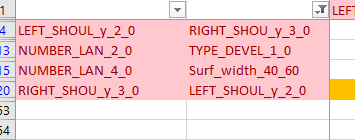

In [14]:
len(df_train)

94200

In [15]:
#df.week_number.value_counts()

### Running the model on train data (changing the base for number of lane- removing NUMBER_LAN_2_0 , now the base is 2lane)

In [17]:

c = 'crashcount_binary ~ log_hv + MEDIAN_TYP_1_0 + MEDIAN_TYP_2_0 +NUMBER_LAN_3_0+NUMBER_LAN_4_0+NUMBER_LAN_5_0+RIGHT_SHOU_x_1_0+RIGHT_SHOU_y_3_0+TERRAIN_2_0+TRUCK_ROUT_1_0+TYPE_DEVEL_1_0+Median_width_below_20'

In [18]:
# === Ridge (L2) classification using formula 'c' ===
from patsy import dmatrices
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV

# Build design matrices from your existing formula 'c' and df_train
y_train, X_train = dmatrices(c, df_train, return_type='dataframe')
y_train = y_train.iloc[:, 0].astype(int)  # ensure 1D int labels

# Cross-validated Ridge with a log-spaced alpha grid
alphas = np.logspace(-4, 4, 20)

# Pipeline: standardize features → RidgeCV
ridge_cv = RidgeClassifierCV(alphas=alphas, store_cv_values=True)
ridge_pipe = make_pipeline(StandardScaler(), ridge_cv)

# Fit the ridge classifier
ridge_pipe.fit(X_train, y_train)

# Report the chosen alpha
best_alpha = ridge_pipe.named_steps['ridgeclassifiercv'].alpha_
print(f"Best alpha (Ridge): {best_alpha:.6g}")


Best alpha (Ridge): 1438.45


In [19]:
# Get calibrated probabilities so downstream code expecting 'pred' keeps working
# (RidgeClassifier doesn't natively output predict_proba; calibration uses CV-Platt scaling.)
calibrated = CalibratedClassifierCV(ridge_pipe, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

predicted_proba = calibrated.predict_proba(X_train)[:, 1]
df_train['pred'] = predicted_proba

print(len(predicted_proba), len(df_train), df_train.isnull().values.any(),
      df_train.isnull().sum().sum(), len(df_train)-len(predicted_proba))


94200 94200 False 0 0


C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\4051679612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['pred'] = predicted_proba


In [83]:
#len(df_T), df1.columns,df_all_1.columns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict probabilities on training data
y_pred = calibrated.predict_proba(X_train)[:, 1]
y_true = y_train.values

# --- RMSE and MAE ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# --- AIC & BIC ---
# For binary outcomes, treat y_pred as the fitted probabilities
eps = 1e-12
log_likelihood = np.sum(
    y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps)
)

n = len(y_true)                      # number of observations
k = X_train.shape[1]                  # number of parameters (features)
aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")


RMSE: 0.1474
MAE: 0.0441
AIC: 19281.57
BIC: 19404.46


In [20]:
df_train.head()

week_number  hourly_volume  Actual_class  LEFT_SHOUL_x_1_0  \
0            1    1223.478499             1               0.0   
1            2    1223.478499             1               0.0   
2            3    1223.478499             1               0.0   
3            4    1223.478499             1               0.0   
4            5    1222.868308             1               0.0   

   LEFT_SHOUL_x_nan  LEFT_SHOUL_y_2_0  LEFT_SHOUL_y_nan  MEDIAN_TYP_1_0  \
0               1.0               1.0               0.0             0.0   
1               1.0               1.0               0.0             0.0   
2               1.0               1.0               0.0             0.0   
3               1.0               1.0               0.0             0.0   
4               1.0               1.0               0.0             0.0   

   MEDIAN_TYP_2_0  MEDIAN_TYP_3_0  ...  Median_width_below_20  \
0             1.0             0.0  ...                    0.0   
1             1.0             0.0  ...                    0.0   
2             1.0             0.0  ...                    0.0   
3             1.0             0.0  ...                    0.0   
4             1.0             0.0  ...                    0.0   

   Surf_width_20_40  Surf_width_40_60  Surf_width_above_60  \
0               1.0               0.0                  0.0   
1               1.0               0.0                  0.0   
2               1.0               0.0                  0.0   
3               1.0               0.0                  0.0   
4               1.0               0.0                  0.0   

   Surf_width_below_20  crash_count  crashcount_binary  segment_id    log_hv  \
0                  0.0          0.0                  0       seg_1  7.109453   
1                  0.0          0.0                  0       seg_1  7.109453   
2                  0.0          0.0                  0       seg_1  7.109453   
3                  0.0          0.0                  0       seg_1  7.109453   
4                  0.0          0.0                  0       seg_1  7.108954   

       pred  
0  0.010875  
1  0.010875  
2  0.010875  
3  0.010875  
4  0.010871  

[5 rows x 56 columns]

In [21]:
### the following picture is for when the probability is calculated from R

the follwing picture is for when the probability is calculated from R
# 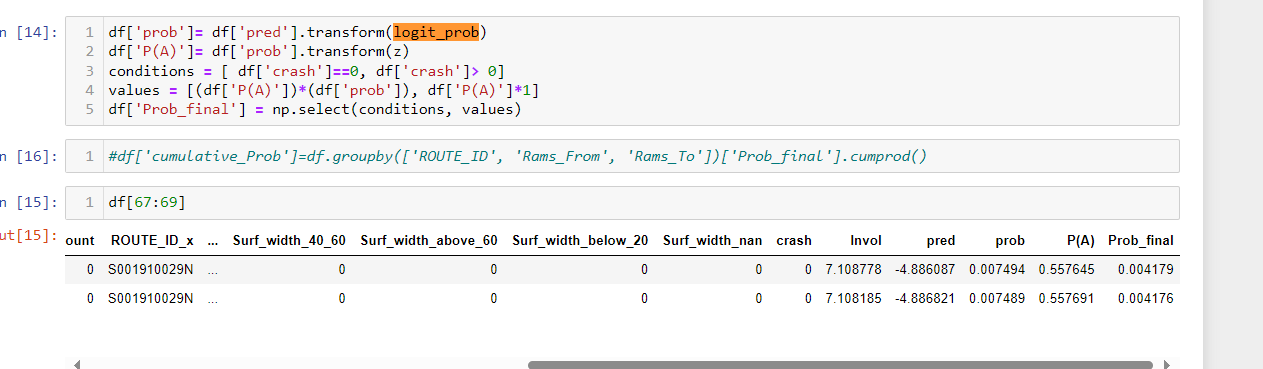

In [22]:
'''def logit_prob(mu):
  # returns the probability of 1 or more crashes
  P = np.exp(mu)/(1+np.exp(mu))
  return P'''

'def logit_prob(mu):\n  # returns the probability of 1 or more crashes\n  P = np.exp(mu)/(1+np.exp(mu))\n  return P'

In [23]:
pbase = round(df_train.crashcount_binary.sum()/len(df_train),3)
pbase

0.023

In [24]:
### Tyhe equation below is used to calculate the weekly crash risk depending on the segment observed a crash on that week

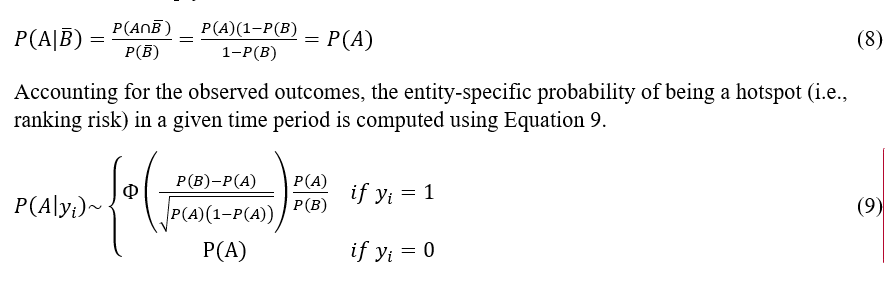

### calculating P(B|A)

In [82]:
### creating this rolling data for 30 weeks of period 
df_train.week_number.max()

30

In [26]:
df.columns

Index(['week_number', 'hourly_volume', 'Actual_class', 'LEFT_SHOUL_x_1_0',
       'LEFT_SHOUL_x_nan', 'LEFT_SHOUL_y_2_0', 'LEFT_SHOUL_y_nan',
       'MEDIAN_TYP_1_0', 'MEDIAN_TYP_2_0', 'MEDIAN_TYP_3_0', 'MEDIAN_TYP_4_0',
       'MEDIAN_TYP_5_0', 'MEDIAN_TYP_nan', 'NUMBER_LAN_1_0', 'NUMBER_LAN_2_0',
       'NUMBER_LAN_3_0', 'NUMBER_LAN_4_0', 'NUMBER_LAN_5_0',
       'RIGHT_SHOU_x_0_0', 'RIGHT_SHOU_x_1_0', 'RIGHT_SHOU_x_nan',
       'RIGHT_SHOU_y_3_0', 'RIGHT_SHOU_y_nan', 'TERRAIN_0_0', 'TERRAIN_1_0',
       'TERRAIN_2_0', 'TERRAIN_3_0', 'TERRAIN_nan', 'TRUCK_ROUT_1_0',
       'TRUCK_ROUT_nan', 'TYPE_DEVEL_1_0', 'TYPE_DEVEL_2_0', 'TYPE_DEVEL_nan',
       'Rt_shoulder_width_0_4', 'Rt_shoulder_width_4_8',
       'Rt_shoulder_width_above_8', 'Lt_shoulder_width_0_4',
       'Lt_shoulder_width_4_8', 'Lt_shoulder_width_above_8',
       'Speed_limit_50_60', 'Speed_limit_60_70', 'Speed_limit_below_50',
       'Median_width_0', 'Median_width_20_50', 'Median_width_50_75',
       'Median_width_abov

In [27]:
df_train = df_train.sort_values(by=['segment_id','week_number'], ascending = True)
df_train.head()

week_number  hourly_volume  Actual_class  LEFT_SHOUL_x_1_0  \
0            1    1223.478499             1               0.0   
1            2    1223.478499             1               0.0   
2            3    1223.478499             1               0.0   
3            4    1223.478499             1               0.0   
4            5    1222.868308             1               0.0   

   LEFT_SHOUL_x_nan  LEFT_SHOUL_y_2_0  LEFT_SHOUL_y_nan  MEDIAN_TYP_1_0  \
0               1.0               1.0               0.0             0.0   
1               1.0               1.0               0.0             0.0   
2               1.0               1.0               0.0             0.0   
3               1.0               1.0               0.0             0.0   
4               1.0               1.0               0.0             0.0   

   MEDIAN_TYP_2_0  MEDIAN_TYP_3_0  ...  Median_width_below_20  \
0             1.0             0.0  ...                    0.0   
1             1.0             0.0  ...                    0.0   
2             1.0             0.0  ...                    0.0   
3             1.0             0.0  ...                    0.0   
4             1.0             0.0  ...                    0.0   

   Surf_width_20_40  Surf_width_40_60  Surf_width_above_60  \
0               1.0               0.0                  0.0   
1               1.0               0.0                  0.0   
2               1.0               0.0                  0.0   
3               1.0               0.0                  0.0   
4               1.0               0.0                  0.0   

   Surf_width_below_20  crash_count  crashcount_binary  segment_id    log_hv  \
0                  0.0          0.0                  0       seg_1  7.109453   
1                  0.0          0.0                  0       seg_1  7.109453   
2                  0.0          0.0                  0       seg_1  7.109453   
3                  0.0          0.0                  0       seg_1  7.109453   
4                  0.0          0.0                  0       seg_1  7.108954   

       pred  
0  0.010875  
1  0.010875  
2  0.010875  
3  0.010875  
4  0.010871  

[5 rows x 56 columns]

In [28]:
## df/ df_all is a dataset with all variables
df_all= df.copy()
'''df_all['crash']= np.where(df_all['crash_count']>0,1,0)
df_all.head(1)'''

"df_all['crash']= np.where(df_all['crash_count']>0,1,0)\ndf_all.head(1)"

In [29]:
df_all.week_number.max(), df_all.crash_count.sum()

(42, 3074.0)

In [30]:
df_train.week_number.max(), df_train.crash_count.sum()

(30, 2236.0)

In [31]:
#checking if the combinations are unique
df_train.groupby(['segment_id', 'week_number'])['hourly_volume'].count().sum(), len(df_train)

(94200, 94200)

In [32]:
df_train.crash_count.value_counts()

crash_count
0.0    92073
1.0     2027
2.0       92
3.0        7
4.0        1
Name: count, dtype: int64

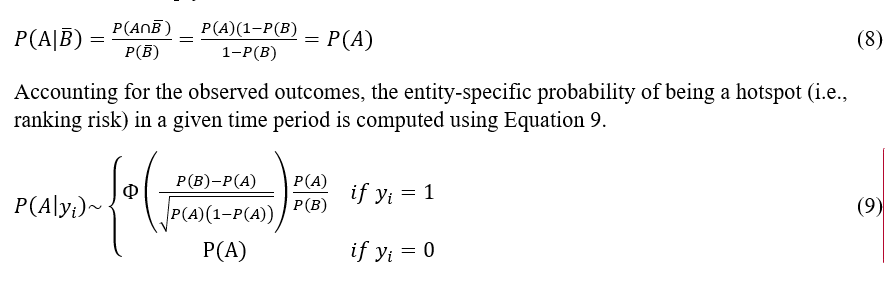

In [33]:
def z(p):
    pbase = round(df_train.crashcount_binary.sum()/len(df_train),3) ### calculating average probability
    z1 = (pbase-p)/np.sqrt(p*(1-p))
    pb1 = norm.cdf(z1)
    pb_y_1 = pb1*(p/pbase)
    return pb_y_1

In [34]:
df_train['prob']= df_train['pred']
## binomial to normal approximation
df_train['P(A|y_1)']= df_train['prob'].transform(z)

In [35]:
df_train['P(A|y_1)'].value_counts()

P(A|y_1)
0.259677    232
0.259688    232
0.259683    232
0.259784    232
0.269258    224
           ... 
2.291171      1
1.704961      1
1.708670      1
1.694850      1
1.100954      1
Name: count, Length: 16033, dtype: int64

In [36]:
df_train.head()

week_number  hourly_volume  Actual_class  LEFT_SHOUL_x_1_0  \
0            1    1223.478499             1               0.0   
1            2    1223.478499             1               0.0   
2            3    1223.478499             1               0.0   
3            4    1223.478499             1               0.0   
4            5    1222.868308             1               0.0   

   LEFT_SHOUL_x_nan  LEFT_SHOUL_y_2_0  LEFT_SHOUL_y_nan  MEDIAN_TYP_1_0  \
0               1.0               1.0               0.0             0.0   
1               1.0               1.0               0.0             0.0   
2               1.0               1.0               0.0             0.0   
3               1.0               1.0               0.0             0.0   
4               1.0               1.0               0.0             0.0   

   MEDIAN_TYP_2_0  MEDIAN_TYP_3_0  ...  Surf_width_40_60  Surf_width_above_60  \
0             1.0             0.0  ...               0.0                  0.0   
1             1.0             0.0  ...               0.0                  0.0   
2             1.0             0.0  ...               0.0                  0.0   
3             1.0             0.0  ...               0.0                  0.0   
4             1.0             0.0  ...               0.0                  0.0   

   Surf_width_below_20  crash_count  crashcount_binary  segment_id    log_hv  \
0                  0.0          0.0                  0       seg_1  7.109453   
1                  0.0          0.0                  0       seg_1  7.109453   
2                  0.0          0.0                  0       seg_1  7.109453   
3                  0.0          0.0                  0       seg_1  7.109453   
4                  0.0          0.0                  0       seg_1  7.108954   

       pred      prob  P(A|y_1)  
0  0.010875  0.010875  0.258423  
1  0.010875  0.010875  0.258423  
2  0.010875  0.010875  0.258423  
3  0.010875  0.010875  0.258423  
4  0.010871  0.010871  0.258323  

[5 rows x 58 columns]

In [37]:
'''
def z(p,cdf_a):
    pbase = round(df_train.crashcount_binary.sum()/len(df_train),3) ### calculating average probability
    #z2 = ((1-pbase)*(1-p))/np.sqrt((p*(1-pbase))*((1-p)*(1-pbase)))
    z2 = (p*(1-cdf_a))/(1-pbase)
    pb2 = norm.cdf(z2)
    return pb2
'''

'\ndef z(p,cdf_a):\n    pbase = round(df_train.crashcount_binary.sum()/len(df_train),3) ### calculating average probability\n    #z2 = ((1-pbase)*(1-p))/np.sqrt((p*(1-pbase))*((1-p)*(1-pbase)))\n    z2 = (p*(1-cdf_a))/(1-pbase)\n    pb2 = norm.cdf(z2)\n    return pb2\n'

In [38]:
'''
df_train['P(A|B_)'] = df_train.apply(
    lambda row: z(row['prob'], row['P(A|B)']), axis=1
)
'''

"\ndf_train['P(A|B_)'] = df_train.apply(\n    lambda row: z(row['prob'], row['P(A|B)']), axis=1\n)\n"

In [39]:
#df_train['prob']= df_train['pred']
## binomial to normal approximation
#df_train['P(A)']= df_train['prob'].transform(z)
### checking the observed crashes to calculate the final probability


#conditions = [ df_train['crashcount_binary']==0, df_train['crashcount_binary']> 0]
#values = [(df_train['P(A)'])*(df_train['prob']), df_train['P(A)']*1]

conditions = [ df_train['crashcount_binary']==0, df_train['crashcount_binary']> 0]
values = [(df_train['pred']), df_train['P(A|y_1)']]

df_train['Prob_final'] = np.select(conditions, values)

In [40]:
df_train.head()

week_number  hourly_volume  Actual_class  LEFT_SHOUL_x_1_0  \
0            1    1223.478499             1               0.0   
1            2    1223.478499             1               0.0   
2            3    1223.478499             1               0.0   
3            4    1223.478499             1               0.0   
4            5    1222.868308             1               0.0   

   LEFT_SHOUL_x_nan  LEFT_SHOUL_y_2_0  LEFT_SHOUL_y_nan  MEDIAN_TYP_1_0  \
0               1.0               1.0               0.0             0.0   
1               1.0               1.0               0.0             0.0   
2               1.0               1.0               0.0             0.0   
3               1.0               1.0               0.0             0.0   
4               1.0               1.0               0.0             0.0   

   MEDIAN_TYP_2_0  MEDIAN_TYP_3_0  ...  Surf_width_above_60  \
0             1.0             0.0  ...                  0.0   
1             1.0             0.0  ...                  0.0   
2             1.0             0.0  ...                  0.0   
3             1.0             0.0  ...                  0.0   
4             1.0             0.0  ...                  0.0   

   Surf_width_below_20  crash_count  crashcount_binary  segment_id    log_hv  \
0                  0.0          0.0                  0       seg_1  7.109453   
1                  0.0          0.0                  0       seg_1  7.109453   
2                  0.0          0.0                  0       seg_1  7.109453   
3                  0.0          0.0                  0       seg_1  7.109453   
4                  0.0          0.0                  0       seg_1  7.108954   

       pred      prob  P(A|y_1)  Prob_final  
0  0.010875  0.010875  0.258423    0.010875  
1  0.010875  0.010875  0.258423    0.010875  
2  0.010875  0.010875  0.258423    0.010875  
3  0.010875  0.010875  0.258423    0.010875  
4  0.010871  0.010871  0.258323    0.010871  

[5 rows x 59 columns]

# df_all is the dataframe  for all data, which have the test data

In [41]:
norm.cdf(0)

0.5

In [42]:
df_all.week_number.max()

42

In [43]:
df_all.crash_count.sum(),df_all.crashcount_binary.sum(),len(df_all)

(3074.0, 2922, 131880)

# Input_the_week_number

In [44]:
###3140 segments

In [45]:
train =  [*range(4, 30, 4)]
train.append(30)
test = [3,4,5,6,7,8,9,10,11,12]

In [46]:
train, test

([4, 8, 12, 16, 20, 24, 28, 30], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# <font color='blue'>creating the combination of train week with 4,8,12,16.... weeks of data</font> 

In [47]:
train_start =[]
train_end = []
train_week =[]

In [48]:
for tr_wk in train:
    train_start1 = [*range(1, 30-(tr_wk-1)+1, 1)] # change 4 to consecutive test week number
    train_start.extend(train_start1)
    train_end1 = [(z+(tr_wk-1)) for z in train_start1]
    train_end.extend(train_end1)
for a,b in zip(train_start,train_end):
    train_week1 = [b-a+1]
    train_week.extend(train_week1)

### <font color='red'>Checking if the previous cell combination is ok or not</font>

In [49]:
for a,b,c in zip(train_start,train_end,train_week):
    print(a,b,c)
    if (b-a+1)!=c:
        print("not ok")
    else:
        continue

1 4 4
2 5 4
3 6 4
4 7 4
5 8 4
6 9 4
7 10 4
8 11 4
9 12 4
10 13 4
11 14 4
12 15 4
13 16 4
14 17 4
15 18 4
16 19 4
17 20 4
18 21 4
19 22 4
20 23 4
21 24 4
22 25 4
23 26 4
24 27 4
25 28 4
26 29 4
27 30 4
1 8 8
2 9 8
3 10 8
4 11 8
5 12 8
6 13 8
7 14 8
8 15 8
9 16 8
10 17 8
11 18 8
12 19 8
13 20 8
14 21 8
15 22 8
16 23 8
17 24 8
18 25 8
19 26 8
20 27 8
21 28 8
22 29 8
23 30 8
1 12 12
2 13 12
3 14 12
4 15 12
5 16 12
6 17 12
7 18 12
8 19 12
9 20 12
10 21 12
11 22 12
12 23 12
13 24 12
14 25 12
15 26 12
16 27 12
17 28 12
18 29 12
19 30 12
1 16 16
2 17 16
3 18 16
4 19 16
5 20 16
6 21 16
7 22 16
8 23 16
9 24 16
10 25 16
11 26 16
12 27 16
13 28 16
14 29 16
15 30 16
1 20 20
2 21 20
3 22 20
4 23 20
5 24 20
6 25 20
7 26 20
8 27 20
9 28 20
10 29 20
11 30 20
1 24 24
2 25 24
3 26 24
4 27 24
5 28 24
6 29 24
7 30 24
1 28 28
2 29 28
3 30 28
1 30 30


# <font color='Green'>-----------------OK---------------------------</font>

In [50]:
ranges = [*range(0, 3140, 100)]
ranges.append(3140)
start= ranges[:-1]
end = ranges[1:]

In [51]:
test = [6,8,10,12]

In [52]:
df_train = df_train.sort_values(by=['segment_id','week_number'], ascending = True)

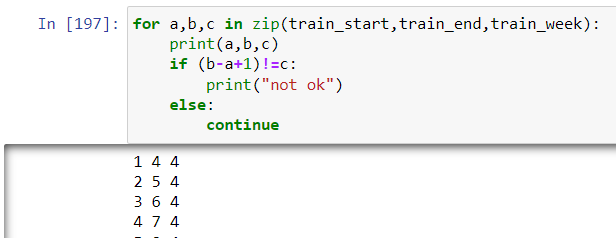

In [53]:
df_all.head(2)

week_number  hourly_volume  Actual_class  LEFT_SHOUL_x_1_0  \
0            1    1223.478499             1               0.0   
1            2    1223.478499             1               0.0   

   LEFT_SHOUL_x_nan  LEFT_SHOUL_y_2_0  LEFT_SHOUL_y_nan  MEDIAN_TYP_1_0  \
0               1.0               1.0               0.0             0.0   
1               1.0               1.0               0.0             0.0   

   MEDIAN_TYP_2_0  MEDIAN_TYP_3_0  ...  Median_width_above_75  \
0             1.0             0.0  ...                    0.0   
1             1.0             0.0  ...                    0.0   

   Median_width_below_20  Surf_width_20_40  Surf_width_40_60  \
0                    0.0               1.0               0.0   
1                    0.0               1.0               0.0   

   Surf_width_above_60  Surf_width_below_20  crash_count  crashcount_binary  \
0                  0.0                  0.0          0.0                  0   
1                  0.0                  0.0          0.0                  0   

   segment_id    log_hv  
0       seg_1  7.109453  
1       seg_1  7.109453  

[2 rows x 55 columns]

In [54]:
'''d1 = pd.DataFrame(columns = ['No_crash', '1 or more crash', 'start', 'end', 'train_start','train_end','train','test','train_test','Total_crash'])
d2 = pd.DataFrame(columns = ['No_crash', '1 or more crash', 'start', 'end', 'train_start','train_end','train','test','train_test','Total_crash'])
d4 = pd.DataFrame()'''

"d1 = pd.DataFrame(columns = ['No_crash', '1 or more crash', 'start', 'end', 'train_start','train_end','train','test','train_test','Total_crash'])\nd2 = pd.DataFrame(columns = ['No_crash', '1 or more crash', 'start', 'end', 'train_start','train_end','train','test','train_test','Total_crash'])\nd4 = pd.DataFrame()"

In [55]:
d4 = pd.DataFrame()

In [56]:
for train_start2,train_end2,train_week2 in zip(train_start,train_end,train_week):
    for test_week in test:
        if ((train_end2-train_start2)+1) == train_week2:
            print("ok")
            print("")
        print(train_start2,train_end2,train_week2,(train_end2-train_start2)+1,test_week)

ok

1 4 4 4 6
ok

1 4 4 4 8
ok

1 4 4 4 10
ok

1 4 4 4 12
ok

2 5 4 4 6
ok

2 5 4 4 8
ok

2 5 4 4 10
ok

2 5 4 4 12
ok

3 6 4 4 6
ok

3 6 4 4 8
ok

3 6 4 4 10
ok

3 6 4 4 12
ok

4 7 4 4 6
ok

4 7 4 4 8
ok

4 7 4 4 10
ok

4 7 4 4 12
ok

5 8 4 4 6
ok

5 8 4 4 8
ok

5 8 4 4 10
ok

5 8 4 4 12
ok

6 9 4 4 6
ok

6 9 4 4 8
ok

6 9 4 4 10
ok

6 9 4 4 12
ok

7 10 4 4 6
ok

7 10 4 4 8
ok

7 10 4 4 10
ok

7 10 4 4 12
ok

8 11 4 4 6
ok

8 11 4 4 8
ok

8 11 4 4 10
ok

8 11 4 4 12
ok

9 12 4 4 6
ok

9 12 4 4 8
ok

9 12 4 4 10
ok

9 12 4 4 12
ok

10 13 4 4 6
ok

10 13 4 4 8
ok

10 13 4 4 10
ok

10 13 4 4 12
ok

11 14 4 4 6
ok

11 14 4 4 8
ok

11 14 4 4 10
ok

11 14 4 4 12
ok

12 15 4 4 6
ok

12 15 4 4 8
ok

12 15 4 4 10
ok

12 15 4 4 12
ok

13 16 4 4 6
ok

13 16 4 4 8
ok

13 16 4 4 10
ok

13 16 4 4 12
ok

14 17 4 4 6
ok

14 17 4 4 8
ok

14 17 4 4 10
ok

14 17 4 4 12
ok

15 18 4 4 6
ok

15 18 4 4 8
ok

15 18 4 4 10
ok

15 18 4 4 12
ok

16 19 4 4 6
ok

16 19 4 4 8
ok

16 19 4 4 10
ok

16 19 4 4 12
ok



In [57]:
start, end

([0,
  100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100],
 [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3140])

In [58]:
df_train.columns, df.columns

(Index(['week_number', 'hourly_volume', 'Actual_class', 'LEFT_SHOUL_x_1_0',
        'LEFT_SHOUL_x_nan', 'LEFT_SHOUL_y_2_0', 'LEFT_SHOUL_y_nan',
        'MEDIAN_TYP_1_0', 'MEDIAN_TYP_2_0', 'MEDIAN_TYP_3_0', 'MEDIAN_TYP_4_0',
        'MEDIAN_TYP_5_0', 'MEDIAN_TYP_nan', 'NUMBER_LAN_1_0', 'NUMBER_LAN_2_0',
        'NUMBER_LAN_3_0', 'NUMBER_LAN_4_0', 'NUMBER_LAN_5_0',
        'RIGHT_SHOU_x_0_0', 'RIGHT_SHOU_x_1_0', 'RIGHT_SHOU_x_nan',
        'RIGHT_SHOU_y_3_0', 'RIGHT_SHOU_y_nan', 'TERRAIN_0_0', 'TERRAIN_1_0',
        'TERRAIN_2_0', 'TERRAIN_3_0', 'TERRAIN_nan', 'TRUCK_ROUT_1_0',
        'TRUCK_ROUT_nan', 'TYPE_DEVEL_1_0', 'TYPE_DEVEL_2_0', 'TYPE_DEVEL_nan',
        'Rt_shoulder_width_0_4', 'Rt_shoulder_width_4_8',
        'Rt_shoulder_width_above_8', 'Lt_shoulder_width_0_4',
        'Lt_shoulder_width_4_8', 'Lt_shoulder_width_above_8',
        'Speed_limit_50_60', 'Speed_limit_60_70', 'Speed_limit_below_50',
        'Median_width_0', 'Median_width_20_50', 'Median_width_50_75',
        'Me

In [59]:
df_train1 = df_train.copy()
df_all1 = df_all.copy()

In [60]:
df_train = df_train[['segment_id', 'week_number',  'pred', 'prob', 'P(A|y_1)', 'Prob_final']].copy()
df_all = df_all[['segment_id', 'week_number', 'crash_count', 'crashcount_binary']].copy()

In [61]:
df_train = df_train.sort_values(by = ['segment_id', 'week_number'], ascending = True)
df_train.head(3)

segment_id  week_number      pred      prob  P(A|y_1)  Prob_final
0      seg_1            1  0.010875  0.010875  0.258423    0.010875
1      seg_1            2  0.010875  0.010875  0.258423    0.010875
2      seg_1            3  0.010875  0.010875  0.258423    0.010875

In [62]:
# taking log of the Prob_final
df_train['Prob_final_log'] = np.log(df_train['Prob_final'])

RMSE: 0.1474
MAE: 0.0441
AIC: 19281.57
BIC: 19404.46


In [64]:
d1 = pd.DataFrame(columns = ['No_crash', '1 or more crash', 'start', 'end', 'train_start','train_end','train','test','train_test','Total_crash'])
d2 = pd.DataFrame(columns = ['No_crash', '1 or more crash', 'start', 'end', 'train_start','train_end','train','test','train_test','Total_crash'])
d4 = pd.DataFrame()

In [66]:
for train_start2,train_end2,train_week2 in zip(train_start,train_end,train_week):
    # filtering the train week by train start and train end
    df1 = df_train[(df_train['week_number']>=train_start2) & (df_train['week_number']<=train_end2) ]
    # calculating the cumulative sum of log probability for certain train week period
    df1['cumulative_Prob_log']=df1.groupby(['segment_id'])['Prob_final_log'].cumsum()
    # adding week start and week end in the dataframe to track the loop
    #df1.loc[:, 'week_end']
    df1.loc[:,'week_start']= train_start2
    df1.loc[:, 'week_end']= train_end2
    df1.loc[:,'week_interval']= train_week2
    # only taking the last week as the cumulative probility is on the last week row
    df1 = df1[(df1['week_number']==train_end2) ] 
    # the length of the segments should be 3140 
    
    #print(len(df1), "for", train_start2,train_end2,train_week2, test_week)
    #sorting the data- hightest probability means highest crash risk
    df1 = df1.sort_values(by=['cumulative_Prob_log'], ascending = False)
    df1 = df1[['segment_id','week_number','week_start','week_end','week_interval','cumulative_Prob_log']].copy()
    #print(train_start2,train_end2,train_week2,(train_end2-train_start2),test_week,"for", len(df1))
    if len(df1)!= 3140:
        print("not ok, check further")
    else:
        print("ok")
    d4 = d4._append(df1)


C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cumulative_Prob_log']=df1.groupby(['segment_id'])['Prob_final_log'].cumsum()
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'week_start']= train_start2
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cumulative_Prob_log']=df1.groupby(['segment_id'])['Prob_final_log'].cumsum()
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'week_start']= train_start2
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cumulative_Prob_log']=df1.groupby(['segment_id'])['Prob_final_log'].cumsum()
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'week_start']= train_start2
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cumulative_Prob_log']=df1.groupby(['segment_id'])['Prob_final_log'].cumsum()
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'week_start']= train_start2
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cumulative_Prob_log']=df1.groupby(['segment_id'])['Prob_final_log'].cumsum()
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'week_start']= train_start2
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cumulative_Prob_log']=df1.groupby(['segment_id'])['Prob_final_log'].cumsum()
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'week_start']= train_start2
C:\Users\maroa\AppData\Local\Temp\ipykernel_76180\1673879173.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [67]:
#total 106 combinations
len(d4), 3140*106

(332840, 332840)

In [68]:
d4.head()

segment_id  week_number  week_start  week_end  week_interval  \
113781   seg_2719            4           1         4              4   
71697    seg_1520            4           1         4              4   
113739   seg_2718            4           1         4              4   
113697   seg_2717            4           1         4              4   
113529   seg_2713            4           1         4              4   

        cumulative_Prob_log  
113781             0.023379  
71697             -0.463024  
113739            -1.181924  
113697            -2.589948  
113529            -3.259829

### takiing only the last 4, 8, 12... weeks of train data instead of taking all combinations

In [69]:
d4_only_last = d4[d4['week_end']==30]
len(d4_only_last), 3140*8

(25120, 25120)

In [70]:
d4_only_last.week_start.value_counts()

week_start
27    3140
23    3140
19    3140
15    3140
11    3140
7     3140
3     3140
1     3140
Name: count, dtype: int64

In [71]:


d4_only_last.to_csv("all_segment_only_last_week_jan2_2025.csv", index = False)

### adding the test week period data for validation

In [72]:
### loading data and filtering for test week period
p = r"anonymized_data_with_crashcount_42_week.csv"
#removing NA values

df = pd.read_csv(p)
df = df.dropna()
df.head()

week_number  hourly_volume  Actual_class  LEFT_SHOUL_x_1.0  \
0            1    1223.478499             1               0.0   
1            2    1223.478499             1               0.0   
2            3    1223.478499             1               0.0   
3            4    1223.478499             1               0.0   
4            5    1222.868308             1               0.0   

   LEFT_SHOUL_x_nan  LEFT_SHOUL_y_2.0  LEFT_SHOUL_y_nan  MEDIAN_TYP_1.0  \
0               1.0               1.0               0.0             0.0   
1               1.0               1.0               0.0             0.0   
2               1.0               1.0               0.0             0.0   
3               1.0               1.0               0.0             0.0   
4               1.0               1.0               0.0             0.0   

   MEDIAN_TYP_2.0  MEDIAN_TYP_3.0  ...  Median_width_50_75  \
0             1.0             0.0  ...                 1.0   
1             1.0             0.0  ...                 1.0   
2             1.0             0.0  ...                 1.0   
3             1.0             0.0  ...                 1.0   
4             1.0             0.0  ...                 1.0   

   Median_width_above_75  Median_width_below_20  Surf_width_20_40  \
0                    0.0                    0.0               1.0   
1                    0.0                    0.0               1.0   
2                    0.0                    0.0               1.0   
3                    0.0                    0.0               1.0   
4                    0.0                    0.0               1.0   

   Surf_width_40_60  Surf_width_above_60  Surf_width_below_20  crash_count  \
0               0.0                  0.0                  0.0          0.0   
1               0.0                  0.0                  0.0          0.0   
2               0.0                  0.0                  0.0          0.0   
3               0.0                  0.0                  0.0          0.0   
4               0.0                  0.0                  0.0          0.0   

   crashcount_binary  segment_id  
0                  0       seg_1  
1                  0       seg_1  
2                  0       seg_1  
3                  0       seg_1  
4                  0       seg_1  

[5 rows x 54 columns]

In [73]:
#taking last 12 weeks of data as test data
df_test = df[(df['week_number']>30) & (df['week_number']<=42)]
len(df_test), 3140*12

(37680, 37680)

In [74]:
df_test.week_number.value_counts()

week_number
31    3140
32    3140
33    3140
34    3140
35    3140
36    3140
37    3140
38    3140
39    3140
40    3140
41    3140
42    3140
Name: count, dtype: int64

In [75]:
1

1

In [76]:
df_test1 = df_test.groupby(['segment_id']).agg({
    'crash_count': 'sum',
    'crashcount_binary': 'sum'
})
df_test1 = df_test1.reset_index()
df_test1 = df_test1.rename(columns={'crash_count': 'crash_count_sum_12wk_test','crashcount_binary': 'crashcount_binary_sum_12wk_test'})
df_test1.head()

segment_id  crash_count_sum_12wk_test  crashcount_binary_sum_12wk_test
0      seg_1                        0.0                                0
1     seg_10                        0.0                                0
2    seg_100                        0.0                                0
3   seg_1000                        0.0                                0
4   seg_1001                        0.0                                0

In [77]:
#838, #795
df_test1.crash_count_sum_12wk_test.sum(), df_test1.crashcount_binary_sum_12wk_test.sum()

(838.0, 795)

In [78]:
d4_only_last.head()

segment_id  week_number  week_start  week_end  week_interval  \
114143   seg_2702           30          27        30              4   
70925    seg_1499           30          27        30              4   
101627   seg_2242           30          27        30              4   
101459   seg_2238           30          27        30              4   
101333   seg_2235           30          27        30              4   

        cumulative_Prob_log  
114143            -0.894223  
70925             -2.886142  
101627            -2.922880  
101459            -3.431949  
101333            -3.524745

In [79]:
d4_only_last = d4_only_last.merge(df_test1, how = 'left', on = ['segment_id'])
d4_only_last.head(2)

segment_id  week_number  week_start  week_end  week_interval  \
0   seg_2702           30          27        30              4   
1   seg_1499           30          27        30              4   

   cumulative_Prob_log  crash_count_sum_12wk_test  \
0            -0.894223                        1.0   
1            -2.886142                        0.0   

   crashcount_binary_sum_12wk_test  
0                                1  
1                                0

In [80]:
len(d4_only_last)/3140

8.0

## below file is used in the next codes

In [81]:
d4_only_last.to_csv("all_segment_only_last_week_with12week_test_jan1_2025.csv", index = False)

# -------------------------------------- end of code1_analysis

In [44]:
##d4_12testwk.to_csv("C:/Users/maroa/Box/Crash Hotspot Detection/1.0 Interstate/ranking_all_Segment_testweek12_nov21_2023.csv", index = False)

In [49]:
#d6.to_csv("C:/Users/maroa/Box/Crash Hotspot Detection/1.0 Interstate/first_200_segment_ranking_Train16week_test8week_01_23_oct_2023.csv")
##df_rank.to_csv("C:/Users/maroa/Box/Crash Hotspot Detection/1.0 Interstate/rank_rolling_average_01_23_oct_2023.csv")

In [ ]:
#https://www.datasciencemadesimple.com/cumulative-product-of-column-in-pandas-python-2/#:~:text=Cumulative%20product%20of%20a%20column%20in%20pandas%20is,column%20df1%20%5B%27cumulative_Tax%27%5D%3Ddf1%20%5B%27Tax%27%5D.cumprod%20%28axis%20%3D%200%29%20df1